# Mask R-CNN - Inspect Trained Pantograph Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import pandas as pd
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Add root to path 
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

# Import Mask RCNN
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from mrcnn.model import utils

# Import pantogrograph class
from dev import pantograph

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "models")

# Set path to root of images. 
DATA_DIR = os.path.join(ROOT_DIR, "datasets/pantograph")

print("Using Root dir:",ROOT_DIR)
print("Using Model dir:",MODEL_DIR)
print("Using Data dir:",DATA_DIR)

/Users/jessedecker/miniconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jessedecker/miniconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/jessedecker/miniconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/jessedecker/miniconda3/envs/tf

I've been imported
Using Root dir: /Users/jessedecker/projects/rail_segmentation
Using Model dir: /Users/jessedecker/projects/rail_segmentation/models
Using Data dir: /Users/jessedecker/projects/rail_segmentation/datasets/pantograph


In [2]:
import tensorflow as tf
print(tf.__version__)

1.14.0


## Configurations

In [3]:
# Load class config and overwrite values as needed
class InferenceConfig(pantograph.PantographConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

config.display()


Configurations Superlee:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        50
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0.5
IMAGE_PADDING                  True
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
KEYPOINT_MASK_POOL_SIZE        7
KEYPOINT_MASK_SHAPE            [56, 56]
KEYPOINT_THRESHOLD             0.005
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.002
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES        

## Notebook Preferences

In [4]:
# Device to load the neural network on. Use CPU to leave GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference" # 'inference' or 'training'

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Dataset

In [5]:
# Load dataset
dataset = pantograph.PantographDataset()
dataset.load_pantograph(DATA_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))

for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
Skeleton: (5, 2)
Keypoint names: (6,)
Image Count: 30
Class Count: 4
  0. BG                                                
  1. front_bar                                         
  2. middle_bar                                        
  3. rear_bar                                          


## Load Model

In [7]:
# Load model using selected device
with tf.device(DEVICE):
    
    # Recreate the model in inference mode
    model = modellib.MaskRCNN(mode="inference", 
                              config=config,
                              model_dir=MODEL_DIR)

    # Set local path to trained weights file
    LOG_DIR = os.path.join(MODEL_DIR, "pantograph20200407T0004")
    MODEL_PATH = os.path.join(LOG_DIR, "mask_rcnn_pantograph_0008.h5")


    # Load trained weights
    model.load_weights(MODEL_PATH, by_name=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead

Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use `tf.cast` instead.


## Test Prediction

In [12]:
'''
Load sample image
'''

# Set random image_id
image_id = random.choice(dataset.image_ids)

# Set specific image_id
image_id = 2

print("image_id ", image_id, dataset.image_reference(image_id))

image_id  2 /home/jupyter/GCP_Test/datasets/pantograph/test/padd_to_swin_frame_76337.jpg


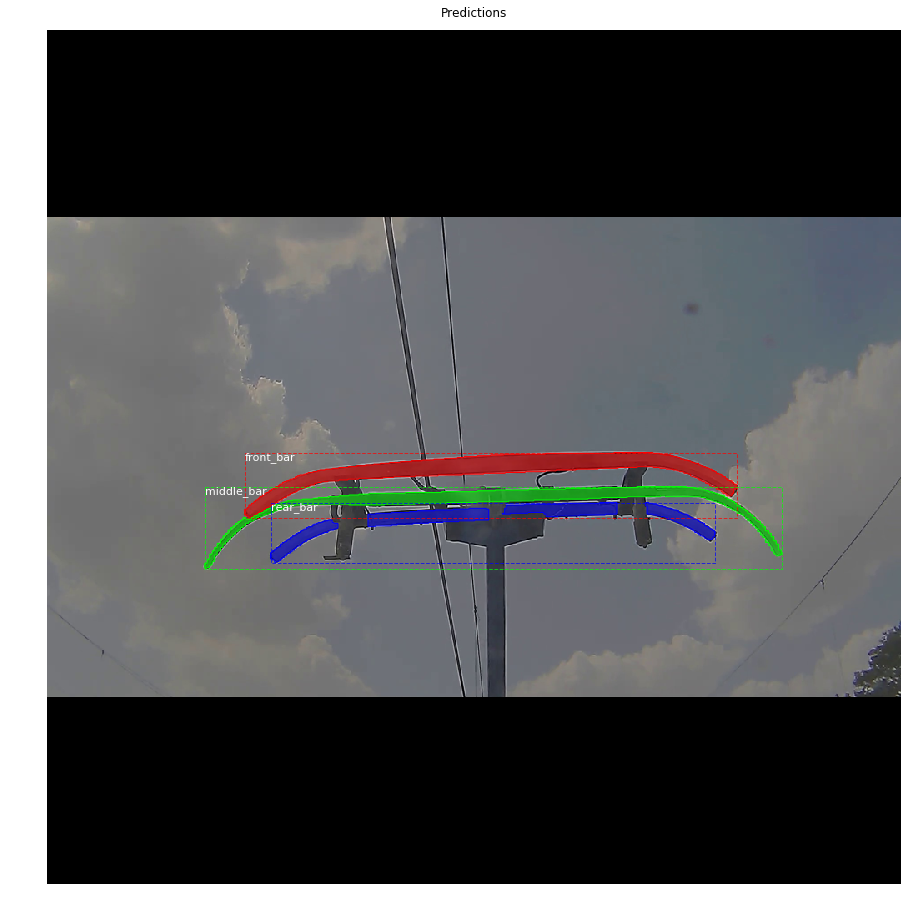

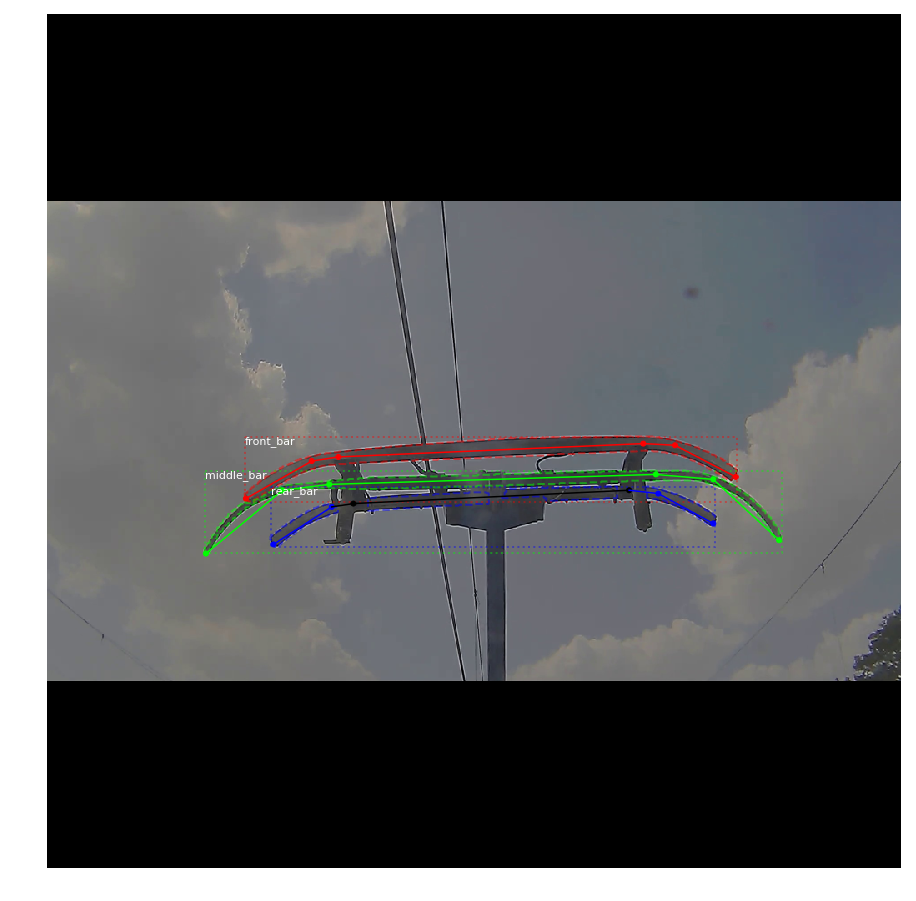

In [13]:
'''
Display Ground Truth Test Image
'''

image, image_meta, class_ids, bbox, masks, keypoints =\
    modellib.load_image_gt_keypoints(dataset, config, 
                           image_id, augment=False,use_mini_mask=True) # Set to False to preview original annotation

# How to ensure alignment/where to get classnames, colors, etc??
# Classnames removes bg
class_names = [dataset.class_names[1:][i-1] for i in class_ids]
# print(len(class_names),len(dataset.class_names))

if masks.shape[0] < image.shape[0]:
    masks = utils.expand_mask(bbox, masks, image.shape)
    
visualize.display_instances(image, bbox, masks, class_ids,dataset.class_names,title="Predictions")
visualize.DrawAnnotations(image,class_ids,class_names,bbox=bbox,masks=masks,keypoints=keypoints,skeleton=dataset.skeleton,figsize=[16,16])

In [14]:
'''
Run Detection
'''

# Reload to be sure no changes
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run detection and get results
results = model.detect_keypoint([image], verbose=1)
r = results[0] # for one image

# Get class names
class_names = [dataset.class_names[1:][i-1] for i in class_ids]

# Expand masks if needed
if masks.shape[0] < image.shape[0]:
    masks = utils.expand_mask(r['rois'], r['masks'], image.shape)
else:
    masks = r['masks']

image ID: pantograph.2 (2) /home/jupyter/GCP_Test/datasets/pantograph/test/padd_to_swin_frame_76337.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000
Molding Inputs
(1, 1024, 1024, 3)
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 12)               min:    0.00000  max: 1024.00000
windows                  shape: (1, 4)                min:    0.00000  max: 1024.00000
Starting Detection
1/1 [==============================] - 6s 6s/step
rpn_class                shape: (1, 65472, 2)         min:    0.00000  max:    1.00000
rpn_bbox                 shape: (1, 65472, 4)         min:   -9.09784  max:   88.21317
rois                     shape: (1, 1000, 4)          min:    0.00000  max:    1.00000
mrcnn_class              shape: (1, 1000, 4)          min:    0.00000  max:    1.00000
mrcnn_bbox               shape: (1, 1000, 4, 4)       min:   -6.08708  max:  

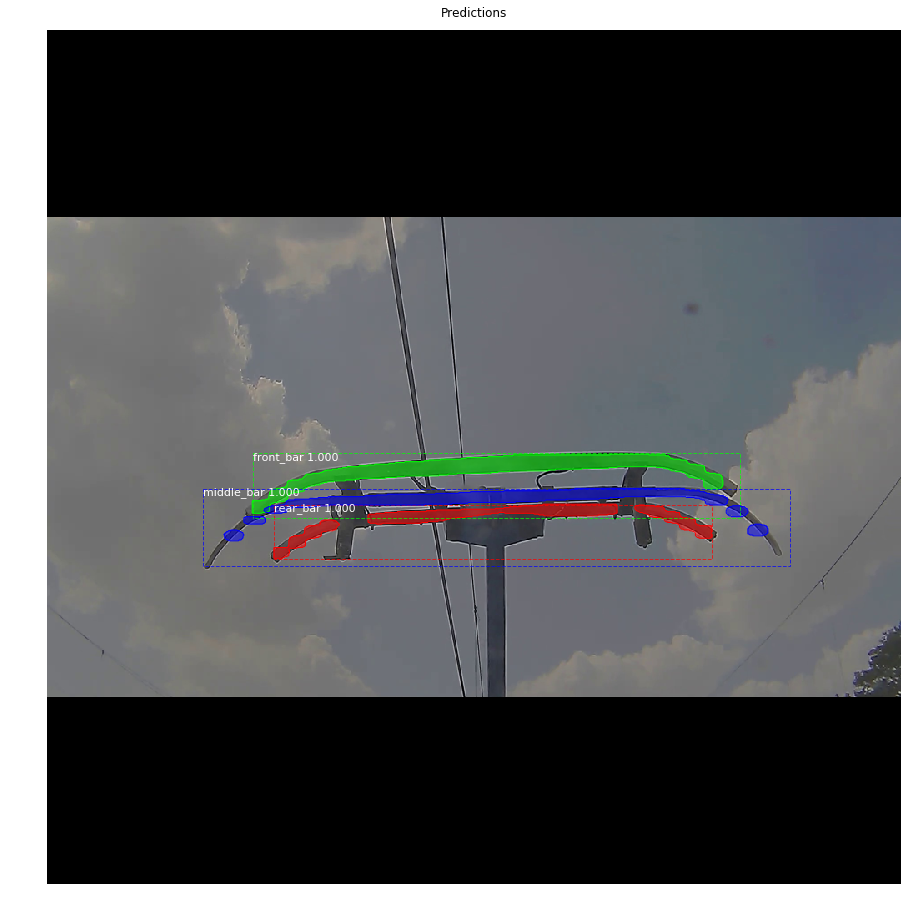

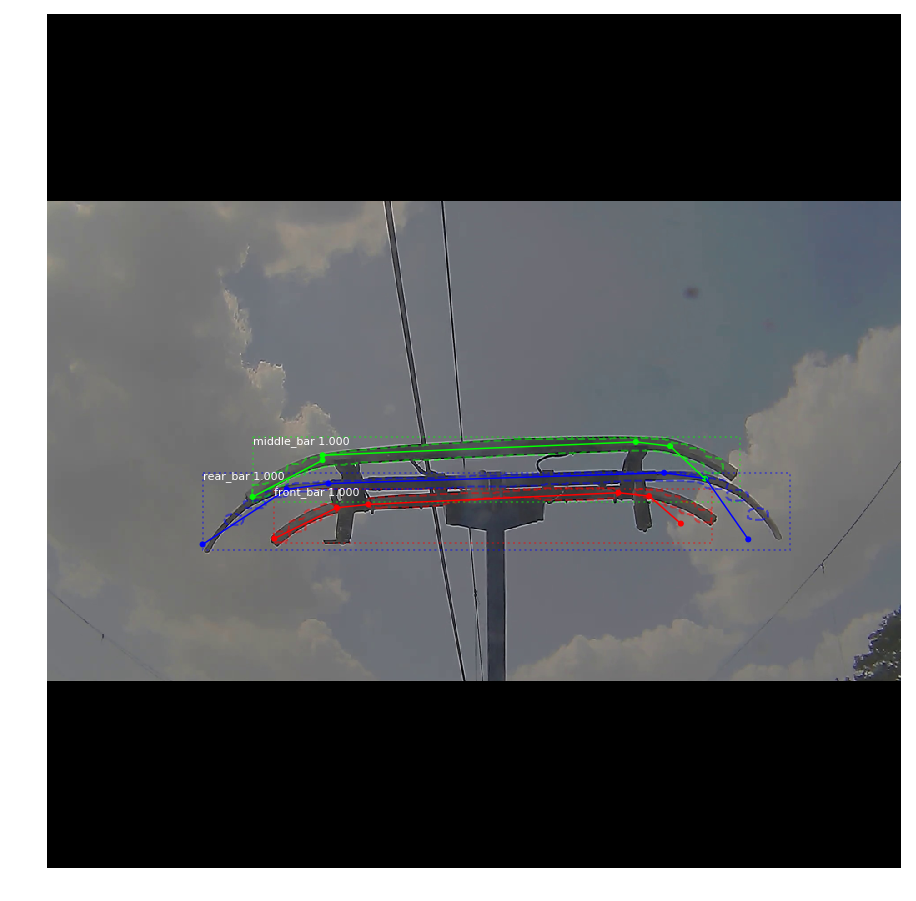

In [15]:
visualize.display_instances(image, r['rois'], masks, r['class_ids'], 
                            dataset.class_names, r['scores'], 
                            title="Predictions")

# Draw vis
visualize.DrawAnnotations(image, 
                          r['class_ids'],
                          class_names=class_names,
                          bbox=r['rois'],
                          masks=masks,
                          keypoints=r['keypoints'],
                          skeleton=dataset.skeleton,
                          scores=r['scores'],
                          figsize=[16,16])

## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [ ]:
# Generate RPN training targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, class_ids, bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )

In [ ]:
# Display positive anchors before refinement (dotted) and after refinement (solid).

print(len(refined_anchors))
visualize.draw_boxes(image, refined_boxes=refined_anchors, ax=get_ax()) # boxes=positive_anchors, 

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [ ]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

    
# orig
# rpn = model.run_graph([[image],
#     ("rpn_class", model.keras_model.get_layer("rpn_class").output),
#     ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
#     ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
#     ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
#     ("post_nms_anchor_ix", nms_node),
#     ("proposals", model.keras_model.get_layer("ROI").output)],[],TEST_MODE = TEST_MODE)

    
# not working
# rpn = model.run_graph([[image],
#     ("rpn_class", model.keras_model.get_layer("rpn_class").output),
#     ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
#     ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
#     ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
#     ("post_nms_anchor_ix", nms_node),
#     ("proposals", model.keras_model.get_layer("ROI").output)],[],TEST_MODE = TEST_MODE)

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output)],TEST_MODE = 'testing')


# Looks right to me but isn't working
# rpn = model.run_graph([image],
#         [("rpn_class", model.keras_model.get_layer("rpn_class").output),
#         ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
#         ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
#         ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
#         ("post_nms_anchor_ix", nms_node),
#         ("proposals", model.keras_model.get_layer("ROI").output)],
#         TEST_MODE=TEST_MODE)

In [ ]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

In [ ]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

In [ ]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

In [ ]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [ ]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output)],TEST_MODE = TEST_MODE)

In [ ]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [ ]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

In [ ]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

#### Apply Bounding Box Refinement

In [ ]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [ ]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

In [ ]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

#### Per-Class Non-Max Suppression

In [ ]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

In [ ]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

In [ ]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [ ]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

In [ ]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

In [ ]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

In [ ]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Stage 4: Inspect the DetectionKeypointTargetLayer
This layers generated the ground truth keypoint labels and their values are between[0, 56*56).
Here we run a sub graph to generated the ground truth target and visulize them to check it.

In [ ]:

# rois, target_class_ids, target_bbox, target_keypoint, target_keypoint_weight, target_mask,
# train_keypoint_generator = modellib.data_generator_keypoint(dataset, config, shuffle=True,
#                                          batch_size=config.BATCH_SIZE)

g = modellib.data_generator_keypoint(dataset, config, shuffle=True, augment=False, 
#                                      random_rois=random_rois,
                                     batch_size=4,
                                     detection_targets=True)

#python 3.* use nexy(generator)
inputs,_ = next(g)

len(inputs)
batch_images, batch_image_meta, batch_rpn_match, batch_rpn_bbox, batch_gt_class_ids, \
            batch_gt_boxes, batch_gt_keypoints,batch_gt_masks  = inputs


rpn = model.run_graph(inputs, [
    ("rois", model.keras_model.get_layer("proposal_targets").output[0]),
    ("target_class_ids", model.keras_model.get_layer("proposal_targets").output[1]),
    ("target_bbox", model.keras_model.get_layer("proposal_targets").output[2]),
    ("target_keypoint_lables", model.keras_model.get_layer("proposal_targets").output[3]),
    ("target_keypoint_weights", model.keras_model.get_layer("proposal_targets").output[4]),
    ("target_mask", model.keras_model.get_layer("proposal_targets").output[5]),
])

roi = rpn["rois"]
target_class_ids = rpn["target_class_ids"]
target_bbox = rpn["target_bbox"]
target_keypoint_label = rpn["target_keypoint_lables"]
target_keypoint_weight = rpn["target_keypoint_weights"]
target_mask = rpn["target_mask"]

# gt_keypoints = rpn["gt_keypoints"]
keypoint_scales = [config.IMAGE_SHAPE[1],config.IMAGE_SHAPE[0],1]
# gt_keypoints = keypoint_scales*gt_keypoints
for i in range(config.BATCH_SIZE):
    batch_orignal_image = modellib.unmold_image(batch_images[i],config)
    visualize.display_image_keypoint_mask(batch_orignal_image,roi[i],target_keypoint_label[i],target_keypoint_weight[i],
                                          target_class_ids[i],train_dataset_keypoints.class_names,config=config,iskeypointlabel= True)



## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [ ]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

In [ ]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

In [ ]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)